In [20]:
import pandas as pd
from glob import glob
from tqdm import tqdm
import json
from model_training_process import *
import requests
import matplotlib.pyplot as plt


In [4]:
class_df = pd.read_csv("..\\tables\\corrected_class_df_pinyin_label_table.csv")
class_df[["pinyin", "class_label"]]

,pinyin,class_label
0,zhi,0
1,chi,0
2,shi,0
3,ri,0
4,zi,1
...,...,...
402,xun,20
403,yong,18
404,jiong,20
405,qiong,20


In [5]:
class_df['class_label_index'] = class_df.groupby('class_label').cumcount()
class_df[["pinyin", "class_label", "class_label_index"]]

,pinyin,class_label,class_label_index
0,zhi,0,0
1,chi,0,1
2,shi,0,2
3,ri,0,3
4,zi,1,0
...,...,...,...
402,xun,20,11
403,yong,18,4
404,jiong,20,12
405,qiong,20,13


In [6]:
npy_file_path_list = glob("..\\..\\data\\*EduVer\\*")
print(f"len(npy_file_path_list): {len(npy_file_path_list)}")

len(npy_file_path_list): 67173


In [7]:
selected_npy_file_path_list = list()
for npy_file_path in npy_file_path_list:
    pinyin = npy_file_path.split("_")[1]
    pinyin_non_accent = pinyin[:-1] if pinyin[-1].isdigit() else pinyin
    if pinyin_non_accent in list(class_df["pinyin"]):
        selected_npy_file_path_list.append(npy_file_path)
print(f"len(npy_file_path_selected): {len(selected_npy_file_path_list)}")

len(npy_file_path_selected): 66852


In [8]:
print(len(class_df.groupby("class_label").count().index))
class_df.groupby("class_label").count().index

21


Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20],
      dtype='int64', name='class_label')

In [9]:
dic = dict()

for i in range(len(class_df.groupby("class_label").count().index)):
    dic[f"class_{i}_mfcc_matrix_list"] = list()
    dic[f"class_{i}_class_label_index_list"] = list()

for npy_file_path in tqdm(selected_npy_file_path_list):
    pinyin = npy_file_path.split("_")[1]
    pinyin_non_accent = pinyin[:-1] if pinyin[-1].isdigit() else pinyin

    class_label = class_df.loc[class_df["pinyin"] == pinyin_non_accent, "class_label"].values[0]
    class_label_index = class_df.loc[class_df["pinyin"] == pinyin_non_accent, "class_label_index"].values[0]
    # print(f"{pinyin_non_accent}, {class_label}, {class_label_index}")

    mfcc_matrix = np.load(npy_file_path)
    dic[f"class_{class_label}_mfcc_matrix_list"].append(mfcc_matrix)
    dic[f"class_{class_label}_class_label_index_list"].append(class_label_index)

for i in range(len(class_df.groupby("class_label").count().index)):
    dic[f"class_{i}_mfcc_matrix_list"] = np.array(dic[f"class_{i}_mfcc_matrix_list"])
    dic[f"class_{i}_class_label_index_list"] = np.array(dic[f"class_{i}_class_label_index_list"])

for i in range(len(class_df.groupby("class_label").count().index)):
    print(f"class_{i}_mfcc_matrix_list.shape: {dic[f'class_{i}_mfcc_matrix_list'].shape}")
    print(f"class_{i}_class_label_index_list.shape: {dic[f'class_{i}_class_label_index_list'].shape}")

100%|██████████| 66852/66852 [00:25<00:00, 2631.93it/s]

class_0_mfcc_matrix_list.shape: (3133, 13, 44)
class_0_class_label_index_list.shape: (3133,)
class_1_mfcc_matrix_list.shape: (844, 13, 44)
class_1_class_label_index_list.shape: (844,)
class_2_mfcc_matrix_list.shape: (1322, 13, 44)
class_2_class_label_index_list.shape: (1322,)
class_3_mfcc_matrix_list.shape: (5333, 13, 44)
class_3_class_label_index_list.shape: (5333,)
class_4_mfcc_matrix_list.shape: (7255, 13, 44)
class_4_class_label_index_list.shape: (7255,)
class_5_mfcc_matrix_list.shape: (4499, 13, 44)
class_5_class_label_index_list.shape: (4499,)
class_6_mfcc_matrix_list.shape: (6060, 13, 44)
class_6_class_label_index_list.shape: (6060,)
class_7_mfcc_matrix_list.shape: (3050, 13, 44)
class_7_class_label_index_list.shape: (3050,)
class_8_mfcc_matrix_list.shape: (3167, 13, 44)
class_8_class_label_index_list.shape: (3167,)
class_9_mfcc_matrix_list.shape: (2396, 13, 44)
class_9_class_label_index_list.shape: (2396,)
class_10_mfcc_matrix_list.shape: (4181, 13, 44)
class_10_class_label_ind

In [10]:
best_params = json.load(open(f"..\\..\\grid_search\\method1_with_fake_data\\best_params.json", "r"))

learning_rate = best_params["learning_rate"]
num_filters = best_params["num_filters"]
dense_units = best_params["dense_unit"]
batch_size = best_params["batch_size"]
epochs = best_params["epochs"]

channel = 1
verbose = 2
num_classes = len(class_df.index)
test_size = 0.2
# mfcc_dim_1 = mfcc_matrix_list.shape[1]
# mfcc_dim_2 = mfcc_matrix_list.shape[2]
# print(f"mfcc_dim_1: {mfcc_dim_1}")
# print(f"mfcc_dim_2: {mfcc_dim_2}")

In [23]:
model_train_info_list = list()
model_list = list()

for i in tqdm(range(len(class_df.groupby("class_label").count().index))):
    X = dic[f"class_{i}_mfcc_matrix_list"]
    y = dic[f"class_{i}_class_label_index_list"]
    
    mfcc_dim_1 = X.shape[1]
    mfcc_dim_2 = X.shape[2]
    
    X_train, X_test, y_train, y_test = get_processed_data(
        X=X,
        y=y,
        num_classes=num_classes,
        mfcc_dim_1=mfcc_dim_1,
        mfcc_dim_2=mfcc_dim_2,
        channel=channel,
        test_size=test_size,
    )

    model = get_cnn_model(input_shape=(mfcc_dim_1, mfcc_dim_2, channel), num_classes=num_classes,
                          learning_rate=learning_rate, num_filters=num_filters, dense_units=dense_units)
    model_train_info = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbose,
                                 validation_data=(X_test, y_test))
    
    model_train_info_list.append(model_train_info)
    model_list.append(model)

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1/250
20/20 - 1s - loss: 5.1838 - accuracy: 0.4034 - val_loss: 5.8293 - val_accuracy: 0.0750 - 1s/epoch - 52ms/step
Epoch 2/250
20/20 - 0s - loss: 3.8108 - accuracy: 0.6273 - val_loss: 5.4370 - val_accuracy: 0.0415 - 232ms/epoch - 12ms/step
Epoch 3/250
20/20 - 0s - loss: 2.6622 - accuracy: 0.6628 - val_loss: 4.9465 - val_accuracy: 0.0415 - 234ms/epoch - 12ms/step
Epoch 4/250
20/20 - 0s - loss: 1.7784 - accuracy: 0.7251 - val_loss: 4.3660 - val_accuracy: 0.0431 - 236ms/epoch - 12ms/step
Epoch 5/250
20/20 - 0s - loss: 1.2887 - accuracy: 0.7626 - val_loss: 3.7582 - val_accuracy: 0.2695 - 233ms/epoch - 12ms/step
Epoch 6/250
20/20 - 0s - loss: 0.9712 - accuracy: 0.7869 - val_loss: 3.1873 - val_accuracy: 0.3541 - 232ms/epoch - 12ms/step
Epoch 7/250
20/20 - 0s - loss: 0.7799 - accuracy: 0.8148 - val_loss: 2.6504 - val_accuracy: 0.6699 - 221ms/epoch - 11ms/step
Epoch 8/250
20/20 - 0s - loss: 0.6806 - accuracy: 0.8292 - val_loss: 2.2883 - val_accuracy: 0.6699 - 236ms/epoch - 12ms/step
Epo

  5%|▍         | 1/21 [00:58<19:32, 58.62s/it]

Epoch 1/250
6/6 - 1s - loss: 5.9583 - accuracy: 0.0341 - val_loss: 6.0017 - val_accuracy: 0.0000e+00 - 708ms/epoch - 118ms/step
Epoch 2/250
6/6 - 0s - loss: 5.2063 - accuracy: 0.2830 - val_loss: 5.9563 - val_accuracy: 0.0000e+00 - 80ms/epoch - 13ms/step
Epoch 3/250
6/6 - 0s - loss: 4.6353 - accuracy: 0.4252 - val_loss: 5.8776 - val_accuracy: 0.2722 - 79ms/epoch - 13ms/step
Epoch 4/250
6/6 - 0s - loss: 4.1957 - accuracy: 0.4474 - val_loss: 5.7624 - val_accuracy: 0.2781 - 75ms/epoch - 13ms/step
Epoch 5/250
6/6 - 0s - loss: 3.8169 - accuracy: 0.5022 - val_loss: 5.6253 - val_accuracy: 0.2781 - 73ms/epoch - 12ms/step
Epoch 6/250
6/6 - 0s - loss: 3.4445 - accuracy: 0.5096 - val_loss: 5.4804 - val_accuracy: 0.2781 - 73ms/epoch - 12ms/step
Epoch 7/250
6/6 - 0s - loss: 3.1370 - accuracy: 0.5393 - val_loss: 5.3226 - val_accuracy: 0.2781 - 73ms/epoch - 12ms/step
Epoch 8/250
6/6 - 0s - loss: 2.7965 - accuracy: 0.5585 - val_loss: 5.1605 - val_accuracy: 0.2781 - 73ms/epoch - 12ms/step
Epoch 9/250
6/

 10%|▉         | 2/21 [01:18<11:15, 35.54s/it]

Epoch 1/250
9/9 - 1s - loss: 5.0879 - accuracy: 0.2535 - val_loss: 5.9985 - val_accuracy: 0.0566 - 784ms/epoch - 87ms/step
Epoch 2/250
9/9 - 0s - loss: 3.9973 - accuracy: 0.3311 - val_loss: 5.9676 - val_accuracy: 0.0453 - 105ms/epoch - 12ms/step
Epoch 3/250
9/9 - 0s - loss: 3.5553 - accuracy: 0.3680 - val_loss: 5.8970 - val_accuracy: 0.0453 - 104ms/epoch - 12ms/step
Epoch 4/250
9/9 - 0s - loss: 3.2215 - accuracy: 0.3926 - val_loss: 5.7884 - val_accuracy: 0.0755 - 106ms/epoch - 12ms/step
Epoch 5/250
9/9 - 0s - loss: 2.9450 - accuracy: 0.4201 - val_loss: 5.6502 - val_accuracy: 0.0453 - 101ms/epoch - 11ms/step
Epoch 6/250
9/9 - 0s - loss: 2.7036 - accuracy: 0.4513 - val_loss: 5.4856 - val_accuracy: 0.0679 - 97ms/epoch - 11ms/step
Epoch 7/250
9/9 - 0s - loss: 2.4924 - accuracy: 0.4598 - val_loss: 5.2900 - val_accuracy: 0.0755 - 105ms/epoch - 12ms/step
Epoch 8/250
9/9 - 0s - loss: 2.3544 - accuracy: 0.4617 - val_loss: 5.0773 - val_accuracy: 0.0755 - 97ms/epoch - 11ms/step
Epoch 9/250
9/9 - 

 14%|█▍        | 3/21 [01:45<09:37, 32.07s/it]

Epoch 1/250
34/34 - 1s - loss: 5.1878 - accuracy: 0.1306 - val_loss: 5.8594 - val_accuracy: 0.0141 - 1s/epoch - 30ms/step
Epoch 2/250
34/34 - 0s - loss: 3.7111 - accuracy: 0.2504 - val_loss: 5.4646 - val_accuracy: 0.0150 - 389ms/epoch - 11ms/step
Epoch 3/250
34/34 - 0s - loss: 2.9777 - accuracy: 0.3249 - val_loss: 4.9387 - val_accuracy: 0.0159 - 395ms/epoch - 12ms/step
Epoch 4/250
34/34 - 0s - loss: 2.6049 - accuracy: 0.3685 - val_loss: 4.4905 - val_accuracy: 0.0169 - 397ms/epoch - 12ms/step
Epoch 5/250
34/34 - 0s - loss: 2.3761 - accuracy: 0.4114 - val_loss: 4.1929 - val_accuracy: 0.0187 - 380ms/epoch - 11ms/step
Epoch 6/250
34/34 - 0s - loss: 2.2175 - accuracy: 0.4463 - val_loss: 4.0005 - val_accuracy: 0.0225 - 384ms/epoch - 11ms/step
Epoch 7/250
34/34 - 0s - loss: 2.0875 - accuracy: 0.4747 - val_loss: 3.8811 - val_accuracy: 0.0562 - 380ms/epoch - 11ms/step
Epoch 8/250
34/34 - 0s - loss: 1.9901 - accuracy: 0.4991 - val_loss: 3.7473 - val_accuracy: 0.0628 - 381ms/epoch - 11ms/step
Epo

 19%|█▉        | 4/21 [03:23<16:24, 57.92s/it]

Epoch 1/250
46/46 - 1s - loss: 4.3000 - accuracy: 0.2957 - val_loss: 5.8138 - val_accuracy: 0.0110 - 1s/epoch - 23ms/step
Epoch 2/250
46/46 - 1s - loss: 2.7226 - accuracy: 0.4016 - val_loss: 5.1907 - val_accuracy: 0.0124 - 505ms/epoch - 11ms/step
Epoch 3/250
46/46 - 1s - loss: 2.1582 - accuracy: 0.4697 - val_loss: 4.6087 - val_accuracy: 0.0214 - 508ms/epoch - 11ms/step
Epoch 4/250
46/46 - 1s - loss: 1.8928 - accuracy: 0.5083 - val_loss: 4.2167 - val_accuracy: 0.0227 - 510ms/epoch - 11ms/step
Epoch 5/250
46/46 - 1s - loss: 1.7202 - accuracy: 0.5467 - val_loss: 3.9653 - val_accuracy: 0.0407 - 515ms/epoch - 11ms/step
Epoch 6/250
46/46 - 1s - loss: 1.5975 - accuracy: 0.5741 - val_loss: 3.6453 - val_accuracy: 0.0924 - 511ms/epoch - 11ms/step
Epoch 7/250
46/46 - 1s - loss: 1.4699 - accuracy: 0.6046 - val_loss: 3.3626 - val_accuracy: 0.2240 - 505ms/epoch - 11ms/step
Epoch 8/250
46/46 - 1s - loss: 1.3497 - accuracy: 0.6487 - val_loss: 3.0845 - val_accuracy: 0.3501 - 512ms/epoch - 11ms/step
Epo

 24%|██▍       | 5/21 [05:33<22:23, 83.94s/it]

Epoch 1/250
29/29 - 1s - loss: 4.9771 - accuracy: 0.1998 - val_loss: 5.8965 - val_accuracy: 0.0200 - 1s/epoch - 38ms/step
Epoch 2/250
29/29 - 0s - loss: 3.5724 - accuracy: 0.2979 - val_loss: 5.5651 - val_accuracy: 0.0200 - 329ms/epoch - 11ms/step
Epoch 3/250
29/29 - 0s - loss: 2.8040 - accuracy: 0.3779 - val_loss: 5.0778 - val_accuracy: 0.0200 - 323ms/epoch - 11ms/step
Epoch 4/250
29/29 - 0s - loss: 2.3710 - accuracy: 0.4184 - val_loss: 4.5759 - val_accuracy: 0.0200 - 325ms/epoch - 11ms/step
Epoch 5/250
29/29 - 0s - loss: 2.1089 - accuracy: 0.4590 - val_loss: 4.1672 - val_accuracy: 0.0200 - 318ms/epoch - 11ms/step
Epoch 6/250
29/29 - 0s - loss: 1.9200 - accuracy: 0.4876 - val_loss: 3.8712 - val_accuracy: 0.1678 - 317ms/epoch - 11ms/step
Epoch 7/250
29/29 - 0s - loss: 1.7850 - accuracy: 0.5196 - val_loss: 3.6790 - val_accuracy: 0.1733 - 337ms/epoch - 12ms/step
Epoch 8/250
29/29 - 0s - loss: 1.6741 - accuracy: 0.5535 - val_loss: 3.5154 - val_accuracy: 0.1767 - 335ms/epoch - 12ms/step
Epo

 29%|██▊       | 6/21 [06:56<20:54, 83.63s/it]

Epoch 1/250
38/38 - 1s - loss: 4.6448 - accuracy: 0.2401 - val_loss: 5.8387 - val_accuracy: 0.0124 - 982ms/epoch - 26ms/step
Epoch 2/250
38/38 - 0s - loss: 3.0952 - accuracy: 0.3616 - val_loss: 5.3401 - val_accuracy: 0.0124 - 435ms/epoch - 11ms/step
Epoch 3/250
38/38 - 0s - loss: 2.4442 - accuracy: 0.4253 - val_loss: 4.7763 - val_accuracy: 0.0206 - 435ms/epoch - 11ms/step
Epoch 4/250
38/38 - 0s - loss: 2.1108 - accuracy: 0.4676 - val_loss: 4.3475 - val_accuracy: 0.0231 - 435ms/epoch - 11ms/step
Epoch 5/250
38/38 - 0s - loss: 1.9258 - accuracy: 0.5054 - val_loss: 4.0635 - val_accuracy: 0.0132 - 419ms/epoch - 11ms/step
Epoch 6/250
38/38 - 0s - loss: 1.7677 - accuracy: 0.5406 - val_loss: 3.8666 - val_accuracy: 0.1592 - 425ms/epoch - 11ms/step
Epoch 7/250
38/38 - 0s - loss: 1.6394 - accuracy: 0.5800 - val_loss: 3.7038 - val_accuracy: 0.1658 - 436ms/epoch - 11ms/step
Epoch 8/250
38/38 - 0s - loss: 1.5150 - accuracy: 0.6093 - val_loss: 3.5430 - val_accuracy: 0.1254 - 421ms/epoch - 11ms/step


 33%|███▎      | 7/21 [08:45<21:28, 92.00s/it]

Epoch 1/250
20/20 - 1s - loss: 5.2643 - accuracy: 0.1967 - val_loss: 6.0112 - val_accuracy: 0.0180 - 841ms/epoch - 42ms/step
Epoch 2/250
20/20 - 0s - loss: 3.9792 - accuracy: 0.2906 - val_loss: 5.9264 - val_accuracy: 0.0180 - 223ms/epoch - 11ms/step
Epoch 3/250
20/20 - 0s - loss: 3.2915 - accuracy: 0.3320 - val_loss: 5.7316 - val_accuracy: 0.0164 - 219ms/epoch - 11ms/step
Epoch 4/250
20/20 - 0s - loss: 2.8152 - accuracy: 0.3754 - val_loss: 5.4789 - val_accuracy: 0.0164 - 232ms/epoch - 12ms/step
Epoch 5/250
20/20 - 0s - loss: 2.5014 - accuracy: 0.4123 - val_loss: 5.2001 - val_accuracy: 0.0164 - 236ms/epoch - 12ms/step
Epoch 6/250
20/20 - 0s - loss: 2.3294 - accuracy: 0.4311 - val_loss: 4.9084 - val_accuracy: 0.0164 - 231ms/epoch - 12ms/step
Epoch 7/250
20/20 - 0s - loss: 2.2041 - accuracy: 0.4426 - val_loss: 4.6816 - val_accuracy: 0.0164 - 228ms/epoch - 11ms/step
Epoch 8/250
20/20 - 0s - loss: 2.0410 - accuracy: 0.4717 - val_loss: 4.4573 - val_accuracy: 0.0164 - 243ms/epoch - 12ms/step


 38%|███▊      | 8/21 [09:43<17:33, 81.04s/it]

Epoch 1/250
20/20 - 1s - loss: 4.8138 - accuracy: 0.4003 - val_loss: 5.9391 - val_accuracy: 0.0820 - 791ms/epoch - 40ms/step
Epoch 2/250
20/20 - 0s - loss: 2.9643 - accuracy: 0.5397 - val_loss: 5.7873 - val_accuracy: 0.0836 - 227ms/epoch - 11ms/step
Epoch 3/250
20/20 - 0s - loss: 2.1101 - accuracy: 0.5977 - val_loss: 5.5135 - val_accuracy: 0.0836 - 236ms/epoch - 12ms/step
Epoch 4/250
20/20 - 0s - loss: 1.5973 - accuracy: 0.6439 - val_loss: 5.1379 - val_accuracy: 0.0852 - 224ms/epoch - 11ms/step
Epoch 5/250
20/20 - 0s - loss: 1.2874 - accuracy: 0.6834 - val_loss: 4.7120 - val_accuracy: 0.0868 - 234ms/epoch - 12ms/step
Epoch 6/250
20/20 - 0s - loss: 1.0858 - accuracy: 0.7027 - val_loss: 4.2619 - val_accuracy: 0.0852 - 238ms/epoch - 12ms/step
Epoch 7/250
20/20 - 0s - loss: 0.9565 - accuracy: 0.7331 - val_loss: 3.8593 - val_accuracy: 0.0899 - 228ms/epoch - 11ms/step
Epoch 8/250
20/20 - 0s - loss: 0.8492 - accuracy: 0.7556 - val_loss: 3.5461 - val_accuracy: 0.0852 - 227ms/epoch - 11ms/step


 43%|████▎     | 9/21 [10:41<14:47, 73.92s/it]

Epoch 1/250
15/15 - 1s - loss: 5.4589 - accuracy: 0.1482 - val_loss: 5.9718 - val_accuracy: 0.0208 - 808ms/epoch - 54ms/step
Epoch 2/250
15/15 - 0s - loss: 4.3407 - accuracy: 0.2516 - val_loss: 5.8665 - val_accuracy: 0.0229 - 170ms/epoch - 11ms/step
Epoch 3/250
15/15 - 0s - loss: 3.5764 - accuracy: 0.3064 - val_loss: 5.6865 - val_accuracy: 0.0188 - 176ms/epoch - 12ms/step
Epoch 4/250
15/15 - 0s - loss: 3.0645 - accuracy: 0.3372 - val_loss: 5.4446 - val_accuracy: 0.0208 - 174ms/epoch - 12ms/step
Epoch 5/250
15/15 - 0s - loss: 2.6785 - accuracy: 0.3841 - val_loss: 5.1612 - val_accuracy: 0.0229 - 173ms/epoch - 12ms/step
Epoch 6/250
15/15 - 0s - loss: 2.3688 - accuracy: 0.4170 - val_loss: 4.8562 - val_accuracy: 0.0188 - 168ms/epoch - 11ms/step
Epoch 7/250
15/15 - 0s - loss: 2.1424 - accuracy: 0.4598 - val_loss: 4.5564 - val_accuracy: 0.0188 - 166ms/epoch - 11ms/step
Epoch 8/250
15/15 - 0s - loss: 1.9637 - accuracy: 0.4890 - val_loss: 4.2744 - val_accuracy: 0.0229 - 181ms/epoch - 12ms/step


 48%|████▊     | 10/21 [11:27<11:57, 65.19s/it]

Epoch 1/250
27/27 - 1s - loss: 5.1188 - accuracy: 0.1654 - val_loss: 5.9433 - val_accuracy: 0.0012 - 865ms/epoch - 32ms/step
Epoch 2/250
27/27 - 0s - loss: 3.6664 - accuracy: 0.2913 - val_loss: 5.6796 - val_accuracy: 0.0239 - 314ms/epoch - 12ms/step
Epoch 3/250
27/27 - 0s - loss: 2.8859 - accuracy: 0.3589 - val_loss: 5.2459 - val_accuracy: 0.0239 - 296ms/epoch - 11ms/step
Epoch 4/250
27/27 - 0s - loss: 2.4280 - accuracy: 0.4145 - val_loss: 4.7475 - val_accuracy: 0.0251 - 300ms/epoch - 11ms/step
Epoch 5/250
27/27 - 0s - loss: 2.1579 - accuracy: 0.4525 - val_loss: 4.3204 - val_accuracy: 0.0323 - 304ms/epoch - 11ms/step
Epoch 6/250
27/27 - 0s - loss: 1.9782 - accuracy: 0.4883 - val_loss: 4.0048 - val_accuracy: 0.0346 - 313ms/epoch - 12ms/step
Epoch 7/250
27/27 - 0s - loss: 1.8316 - accuracy: 0.5129 - val_loss: 3.7947 - val_accuracy: 0.0621 - 299ms/epoch - 11ms/step
Epoch 8/250
27/27 - 0s - loss: 1.7254 - accuracy: 0.5422 - val_loss: 3.6570 - val_accuracy: 0.0526 - 320ms/epoch - 12ms/step


 52%|█████▏    | 11/21 [12:43<11:24, 68.41s/it]

Epoch 1/250
49/49 - 1s - loss: 4.6170 - accuracy: 0.2374 - val_loss: 5.7451 - val_accuracy: 0.0410 - 1s/epoch - 22ms/step
Epoch 2/250
49/49 - 1s - loss: 2.7033 - accuracy: 0.3697 - val_loss: 5.0251 - val_accuracy: 0.0410 - 552ms/epoch - 11ms/step
Epoch 3/250
49/49 - 1s - loss: 2.0568 - accuracy: 0.4465 - val_loss: 4.2925 - val_accuracy: 0.0514 - 536ms/epoch - 11ms/step
Epoch 4/250
49/49 - 1s - loss: 1.7785 - accuracy: 0.4975 - val_loss: 3.8103 - val_accuracy: 0.1080 - 540ms/epoch - 11ms/step
Epoch 5/250
49/49 - 1s - loss: 1.5950 - accuracy: 0.5365 - val_loss: 3.5234 - val_accuracy: 0.1158 - 521ms/epoch - 11ms/step
Epoch 6/250
49/49 - 1s - loss: 1.4652 - accuracy: 0.5777 - val_loss: 3.2489 - val_accuracy: 0.1444 - 537ms/epoch - 11ms/step
Epoch 7/250
49/49 - 1s - loss: 1.3489 - accuracy: 0.6130 - val_loss: 2.9726 - val_accuracy: 0.2010 - 535ms/epoch - 11ms/step
Epoch 8/250
49/49 - 1s - loss: 1.1919 - accuracy: 0.6797 - val_loss: 2.8990 - val_accuracy: 0.1620 - 536ms/epoch - 11ms/step
Epo

 57%|█████▋    | 12/21 [14:57<13:17, 88.58s/it]

Epoch 1/250
12/12 - 1s - loss: 5.0020 - accuracy: 0.3228 - val_loss: 5.9663 - val_accuracy: 0.0431 - 663ms/epoch - 55ms/step
Epoch 2/250
12/12 - 0s - loss: 3.5022 - accuracy: 0.4801 - val_loss: 5.8893 - val_accuracy: 0.0512 - 142ms/epoch - 12ms/step
Epoch 3/250
12/12 - 0s - loss: 2.6782 - accuracy: 0.5442 - val_loss: 5.7425 - val_accuracy: 0.0512 - 141ms/epoch - 12ms/step
Epoch 4/250
12/12 - 0s - loss: 2.0939 - accuracy: 0.5901 - val_loss: 5.5313 - val_accuracy: 0.0512 - 144ms/epoch - 12ms/step
Epoch 5/250
12/12 - 0s - loss: 1.7148 - accuracy: 0.6226 - val_loss: 5.2555 - val_accuracy: 0.0512 - 141ms/epoch - 12ms/step
Epoch 6/250
12/12 - 0s - loss: 1.4706 - accuracy: 0.6563 - val_loss: 4.9455 - val_accuracy: 0.0512 - 125ms/epoch - 10ms/step
Epoch 7/250
12/12 - 0s - loss: 1.2611 - accuracy: 0.6637 - val_loss: 4.6156 - val_accuracy: 0.0512 - 129ms/epoch - 11ms/step
Epoch 8/250
12/12 - 0s - loss: 1.1191 - accuracy: 0.6806 - val_loss: 4.2817 - val_accuracy: 0.0512 - 141ms/epoch - 12ms/step


 62%|██████▏   | 13/21 [15:32<09:39, 72.41s/it]

Epoch 1/250
6/6 - 1s - loss: 5.4900 - accuracy: 0.2765 - val_loss: 6.0007 - val_accuracy: 0.0000e+00 - 618ms/epoch - 103ms/step
Epoch 2/250
6/6 - 0s - loss: 4.3785 - accuracy: 0.4485 - val_loss: 5.9812 - val_accuracy: 0.0468 - 63ms/epoch - 10ms/step
Epoch 3/250
6/6 - 0s - loss: 3.6494 - accuracy: 0.5926 - val_loss: 5.9468 - val_accuracy: 0.0526 - 68ms/epoch - 11ms/step
Epoch 4/250
6/6 - 0s - loss: 3.1024 - accuracy: 0.6368 - val_loss: 5.8890 - val_accuracy: 0.0526 - 73ms/epoch - 12ms/step
Epoch 5/250
6/6 - 0s - loss: 2.7191 - accuracy: 0.6529 - val_loss: 5.8127 - val_accuracy: 0.0526 - 78ms/epoch - 13ms/step
Epoch 6/250
6/6 - 0s - loss: 2.4395 - accuracy: 0.6779 - val_loss: 5.7201 - val_accuracy: 0.0526 - 62ms/epoch - 10ms/step
Epoch 7/250
6/6 - 0s - loss: 2.0633 - accuracy: 0.6882 - val_loss: 5.6098 - val_accuracy: 0.0526 - 78ms/epoch - 13ms/step
Epoch 8/250
6/6 - 0s - loss: 1.8626 - accuracy: 0.6941 - val_loss: 5.4696 - val_accuracy: 0.0526 - 65ms/epoch - 11ms/step
Epoch 9/250
6/6 - 

 67%|██████▋   | 14/21 [15:51<06:33, 56.27s/it]

Epoch 1/250
17/17 - 1s - loss: 5.2551 - accuracy: 0.1802 - val_loss: 5.9496 - val_accuracy: 0.0320 - 743ms/epoch - 44ms/step
Epoch 2/250
17/17 - 0s - loss: 3.9124 - accuracy: 0.2962 - val_loss: 5.8016 - val_accuracy: 0.0320 - 191ms/epoch - 11ms/step
Epoch 3/250
17/17 - 0s - loss: 3.1812 - accuracy: 0.3524 - val_loss: 5.5674 - val_accuracy: 0.0320 - 203ms/epoch - 12ms/step
Epoch 4/250
17/17 - 0s - loss: 2.6877 - accuracy: 0.4142 - val_loss: 5.2574 - val_accuracy: 0.0320 - 191ms/epoch - 11ms/step
Epoch 5/250
17/17 - 0s - loss: 2.3504 - accuracy: 0.4528 - val_loss: 4.9044 - val_accuracy: 0.0320 - 187ms/epoch - 11ms/step
Epoch 6/250
17/17 - 0s - loss: 2.1215 - accuracy: 0.4750 - val_loss: 4.5385 - val_accuracy: 0.0320 - 203ms/epoch - 12ms/step
Epoch 7/250
17/17 - 0s - loss: 1.9387 - accuracy: 0.5000 - val_loss: 4.2140 - val_accuracy: 0.0320 - 192ms/epoch - 11ms/step
Epoch 8/250
17/17 - 0s - loss: 1.8002 - accuracy: 0.5160 - val_loss: 3.9414 - val_accuracy: 0.0320 - 188ms/epoch - 11ms/step


 71%|███████▏  | 15/21 [16:41<05:24, 54.12s/it]

Epoch 1/250
23/23 - 1s - loss: 5.2048 - accuracy: 0.1668 - val_loss: 5.9297 - val_accuracy: 0.0418 - 791ms/epoch - 34ms/step
Epoch 2/250
23/23 - 0s - loss: 3.8596 - accuracy: 0.2760 - val_loss: 5.7248 - val_accuracy: 0.0279 - 271ms/epoch - 12ms/step
Epoch 3/250
23/23 - 0s - loss: 3.0833 - accuracy: 0.3454 - val_loss: 5.3951 - val_accuracy: 0.0237 - 249ms/epoch - 11ms/step
Epoch 4/250
23/23 - 0s - loss: 2.6332 - accuracy: 0.3751 - val_loss: 5.0064 - val_accuracy: 0.0251 - 250ms/epoch - 11ms/step
Epoch 5/250
23/23 - 0s - loss: 2.3568 - accuracy: 0.4082 - val_loss: 4.6244 - val_accuracy: 0.0725 - 266ms/epoch - 12ms/step
Epoch 6/250
23/23 - 0s - loss: 2.1793 - accuracy: 0.4320 - val_loss: 4.3051 - val_accuracy: 0.0711 - 251ms/epoch - 11ms/step
Epoch 7/250
23/23 - 0s - loss: 2.0374 - accuracy: 0.4564 - val_loss: 4.0694 - val_accuracy: 0.0725 - 254ms/epoch - 11ms/step
Epoch 8/250
23/23 - 0s - loss: 1.9230 - accuracy: 0.4815 - val_loss: 3.8750 - val_accuracy: 0.0725 - 259ms/epoch - 11ms/step


 76%|███████▌  | 16/21 [17:45<04:46, 57.27s/it]

Epoch 1/250
23/23 - 1s - loss: 4.9500 - accuracy: 0.1956 - val_loss: 5.9675 - val_accuracy: 0.0109 - 1s/epoch - 46ms/step
Epoch 2/250
23/23 - 0s - loss: 3.6575 - accuracy: 0.2790 - val_loss: 5.7735 - val_accuracy: 0.0109 - 269ms/epoch - 12ms/step
Epoch 3/250
23/23 - 0s - loss: 3.0346 - accuracy: 0.3348 - val_loss: 5.4319 - val_accuracy: 0.0095 - 251ms/epoch - 11ms/step
Epoch 4/250
23/23 - 0s - loss: 2.6162 - accuracy: 0.3811 - val_loss: 5.0373 - val_accuracy: 0.0095 - 267ms/epoch - 12ms/step
Epoch 5/250
23/23 - 0s - loss: 2.3384 - accuracy: 0.4243 - val_loss: 4.6833 - val_accuracy: 0.0299 - 254ms/epoch - 11ms/step
Epoch 6/250
23/23 - 0s - loss: 2.1503 - accuracy: 0.4485 - val_loss: 4.3932 - val_accuracy: 0.0367 - 266ms/epoch - 12ms/step
Epoch 7/250
23/23 - 0s - loss: 1.9979 - accuracy: 0.4937 - val_loss: 4.1691 - val_accuracy: 0.0476 - 269ms/epoch - 12ms/step
Epoch 8/250
23/23 - 0s - loss: 1.8553 - accuracy: 0.5451 - val_loss: 4.0053 - val_accuracy: 0.0476 - 250ms/epoch - 11ms/step
Epo

 81%|████████  | 17/21 [18:51<03:59, 59.87s/it]

Epoch 1/250
14/14 - 1s - loss: 5.4433 - accuracy: 0.1424 - val_loss: 5.9685 - val_accuracy: 0.0260 - 694ms/epoch - 50ms/step
Epoch 2/250
14/14 - 0s - loss: 4.3292 - accuracy: 0.2482 - val_loss: 5.8581 - val_accuracy: 0.0307 - 160ms/epoch - 11ms/step
Epoch 3/250
14/14 - 0s - loss: 3.6095 - accuracy: 0.3032 - val_loss: 5.6747 - val_accuracy: 0.0284 - 156ms/epoch - 11ms/step
Epoch 4/250
14/14 - 0s - loss: 3.0921 - accuracy: 0.3351 - val_loss: 5.4304 - val_accuracy: 0.0260 - 156ms/epoch - 11ms/step
Epoch 5/250
14/14 - 0s - loss: 2.7270 - accuracy: 0.3688 - val_loss: 5.1340 - val_accuracy: 0.0307 - 159ms/epoch - 11ms/step
Epoch 6/250
14/14 - 0s - loss: 2.4742 - accuracy: 0.4025 - val_loss: 4.8130 - val_accuracy: 0.0189 - 156ms/epoch - 11ms/step
Epoch 7/250
14/14 - 0s - loss: 2.2498 - accuracy: 0.4232 - val_loss: 4.4982 - val_accuracy: 0.0189 - 172ms/epoch - 12ms/step
Epoch 8/250
14/14 - 0s - loss: 2.0873 - accuracy: 0.4521 - val_loss: 4.2023 - val_accuracy: 0.0189 - 160ms/epoch - 11ms/step


 86%|████████▌ | 18/21 [19:31<02:41, 53.91s/it]

Epoch 1/250
6/6 - 1s - loss: 5.6193 - accuracy: 0.2066 - val_loss: 5.9949 - val_accuracy: 0.0000e+00 - 604ms/epoch - 101ms/step
Epoch 2/250
6/6 - 0s - loss: 4.2476 - accuracy: 0.5234 - val_loss: 5.9534 - val_accuracy: 0.0769 - 62ms/epoch - 10ms/step
Epoch 3/250
6/6 - 0s - loss: 3.4515 - accuracy: 0.5799 - val_loss: 5.8824 - val_accuracy: 0.0934 - 78ms/epoch - 13ms/step
Epoch 4/250
6/6 - 0s - loss: 2.8515 - accuracy: 0.6102 - val_loss: 5.7856 - val_accuracy: 0.0934 - 78ms/epoch - 13ms/step
Epoch 5/250
6/6 - 0s - loss: 2.4000 - accuracy: 0.6198 - val_loss: 5.6683 - val_accuracy: 0.0989 - 78ms/epoch - 13ms/step
Epoch 6/250
6/6 - 0s - loss: 2.0369 - accuracy: 0.6680 - val_loss: 5.5349 - val_accuracy: 0.0989 - 78ms/epoch - 13ms/step
Epoch 7/250
6/6 - 0s - loss: 1.7631 - accuracy: 0.6680 - val_loss: 5.3855 - val_accuracy: 0.0989 - 67ms/epoch - 11ms/step
Epoch 8/250
6/6 - 0s - loss: 1.5289 - accuracy: 0.6818 - val_loss: 5.2191 - val_accuracy: 0.0989 - 77ms/epoch - 13ms/step
Epoch 9/250
6/6 - 

 90%|█████████ | 19/21 [19:51<01:27, 43.59s/it]

Epoch 1/250
2/2 - 1s - loss: 6.2598 - accuracy: 0.0000e+00 - val_loss: 6.0070 - val_accuracy: 0.0000e+00 - 575ms/epoch - 288ms/step
Epoch 2/250
2/2 - 0s - loss: 5.7382 - accuracy: 0.0854 - val_loss: 6.0019 - val_accuracy: 0.0000e+00 - 32ms/epoch - 16ms/step
Epoch 3/250
2/2 - 0s - loss: 5.3431 - accuracy: 0.2010 - val_loss: 5.9933 - val_accuracy: 0.0000e+00 - 31ms/epoch - 15ms/step
Epoch 4/250
2/2 - 0s - loss: 5.0385 - accuracy: 0.3367 - val_loss: 5.9832 - val_accuracy: 0.2800 - 30ms/epoch - 15ms/step
Epoch 5/250
2/2 - 0s - loss: 4.7523 - accuracy: 0.4271 - val_loss: 5.9711 - val_accuracy: 0.2200 - 31ms/epoch - 15ms/step
Epoch 6/250
2/2 - 0s - loss: 4.4800 - accuracy: 0.4422 - val_loss: 5.9557 - val_accuracy: 0.2200 - 28ms/epoch - 14ms/step
Epoch 7/250
2/2 - 0s - loss: 4.2409 - accuracy: 0.4623 - val_loss: 5.9371 - val_accuracy: 0.2200 - 32ms/epoch - 16ms/step
Epoch 8/250
2/2 - 0s - loss: 4.0852 - accuracy: 0.4724 - val_loss: 5.9167 - val_accuracy: 0.2400 - 31ms/epoch - 16ms/step
Epoch 

 95%|█████████▌| 20/21 [19:59<00:33, 33.01s/it]

Epoch 1/250
13/13 - 1s - loss: 5.5508 - accuracy: 0.1869 - val_loss: 5.9940 - val_accuracy: 0.0244 - 675ms/epoch - 52ms/step
Epoch 2/250
13/13 - 0s - loss: 4.4643 - accuracy: 0.2657 - val_loss: 5.9402 - val_accuracy: 0.0244 - 152ms/epoch - 12ms/step
Epoch 3/250
13/13 - 0s - loss: 3.8275 - accuracy: 0.3018 - val_loss: 5.8282 - val_accuracy: 0.0220 - 161ms/epoch - 12ms/step
Epoch 4/250
13/13 - 0s - loss: 3.2534 - accuracy: 0.3427 - val_loss: 5.6554 - val_accuracy: 0.0390 - 146ms/epoch - 11ms/step
Epoch 5/250
13/13 - 0s - loss: 2.8146 - accuracy: 0.3897 - val_loss: 5.4407 - val_accuracy: 0.0293 - 157ms/epoch - 12ms/step
Epoch 6/250
13/13 - 0s - loss: 2.4618 - accuracy: 0.4319 - val_loss: 5.1833 - val_accuracy: 0.0293 - 141ms/epoch - 11ms/step
Epoch 7/250
13/13 - 0s - loss: 2.2007 - accuracy: 0.4624 - val_loss: 4.8963 - val_accuracy: 0.0317 - 144ms/epoch - 11ms/step
Epoch 8/250
13/13 - 0s - loss: 1.9948 - accuracy: 0.4887 - val_loss: 4.6298 - val_accuracy: 0.0268 - 156ms/epoch - 12ms/step


100%|██████████| 21/21 [20:38<00:00, 58.96s/it]


In [24]:
# DISCORD -> 設定 -> 整合 -> Webhook -> 新 Webhook > -> 複製 Webhook 網址
DISCORD_WEBHOOK_URL = "https://discord.com/api/webhooks/1287413088970346557/30gx7NdIfSxS1BRWk28IRkOHJeoET-ihIN_KAjYeXYkrpPeI0hBnE-68AHzhpTR4h3et"
requests.post(
    url=DISCORD_WEBHOOK_URL,
    data={"content": "cnn method2 layer2 with fake data模型訓練已完成!"}
)

<Response [204]>

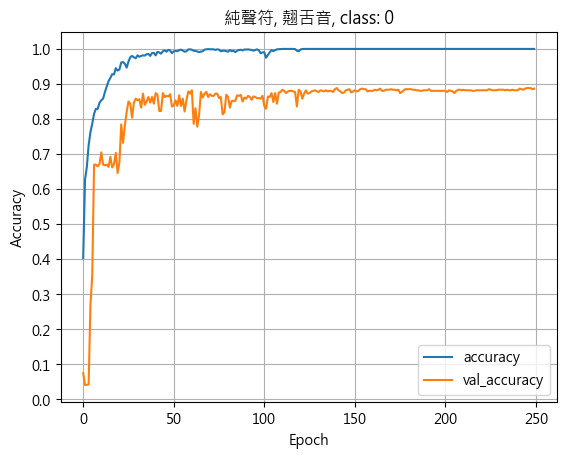

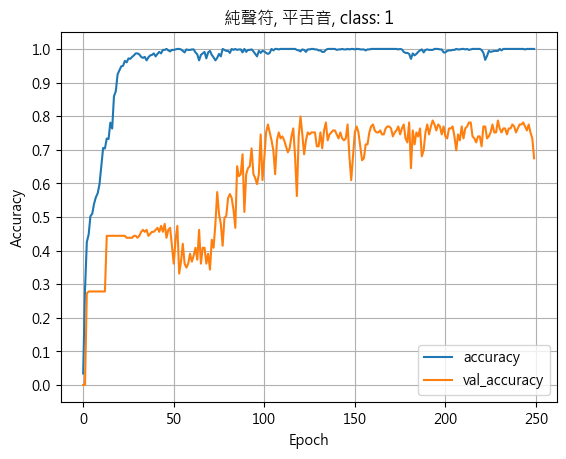

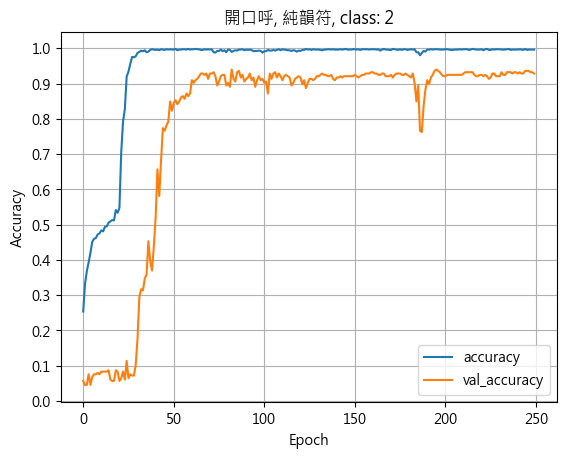

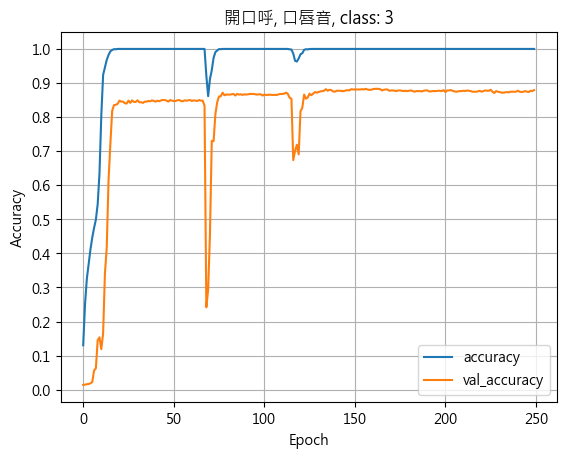

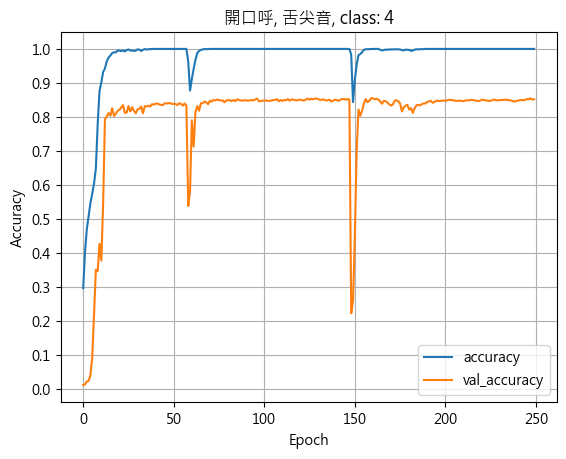

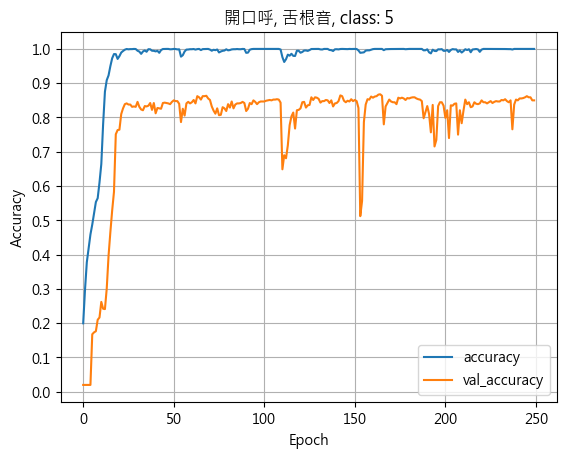

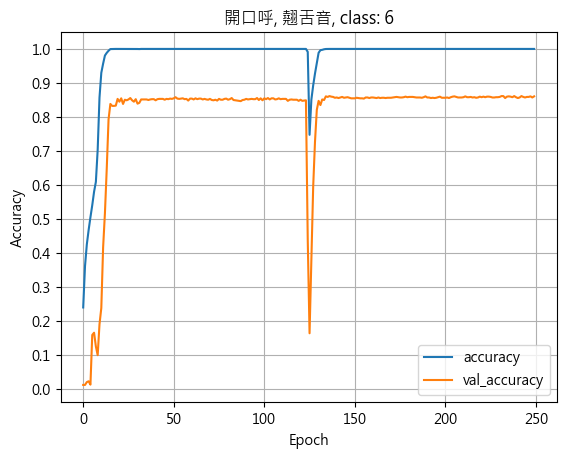

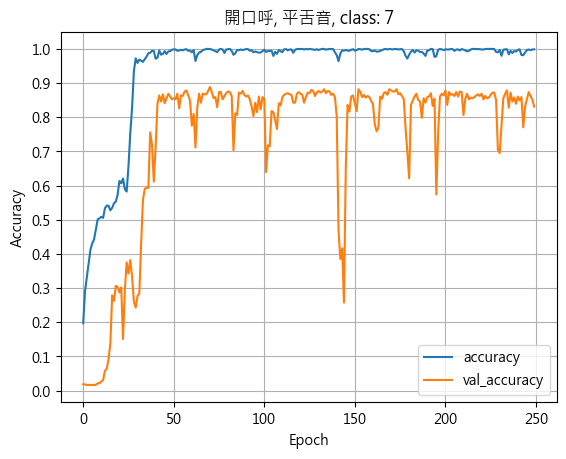

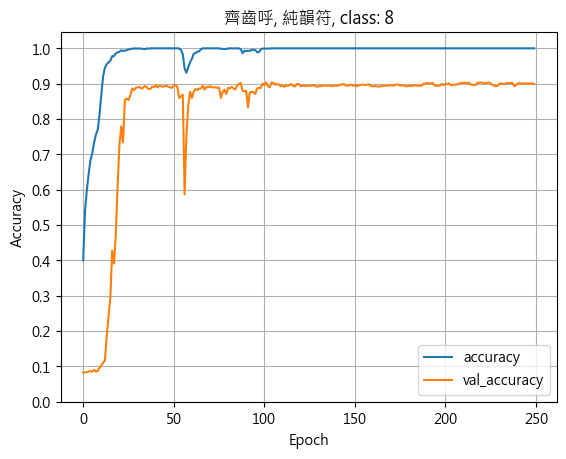

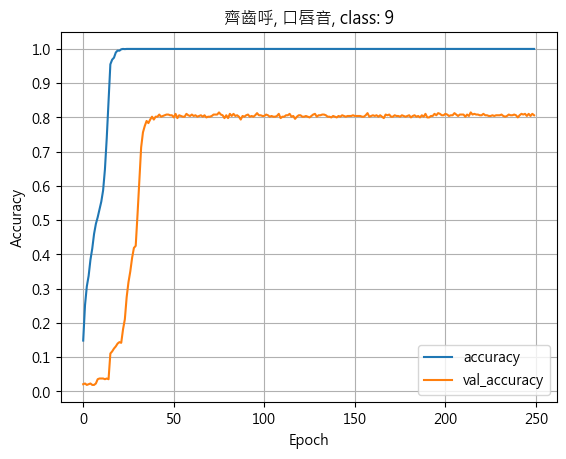

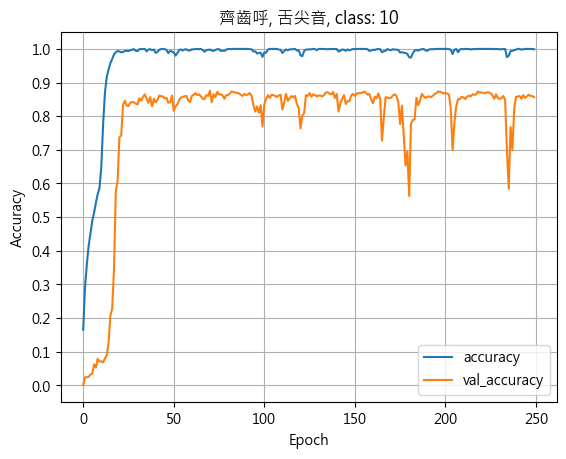

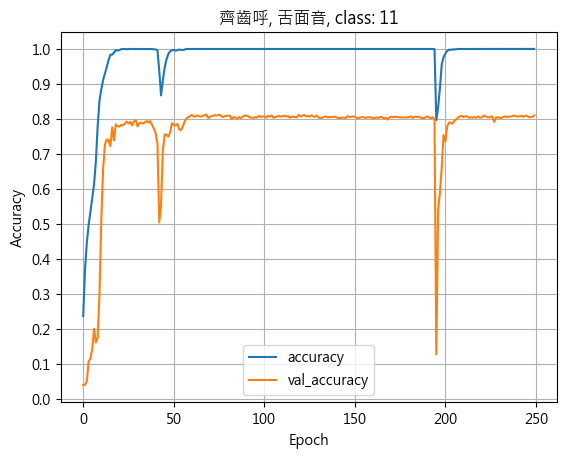

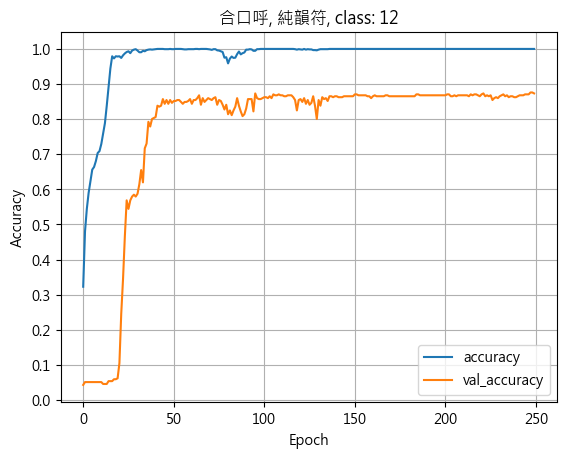

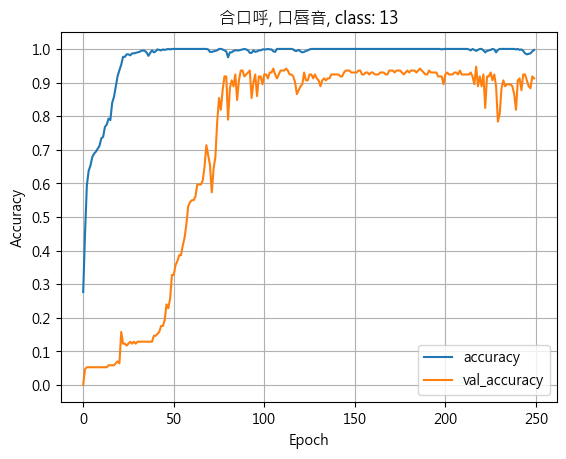

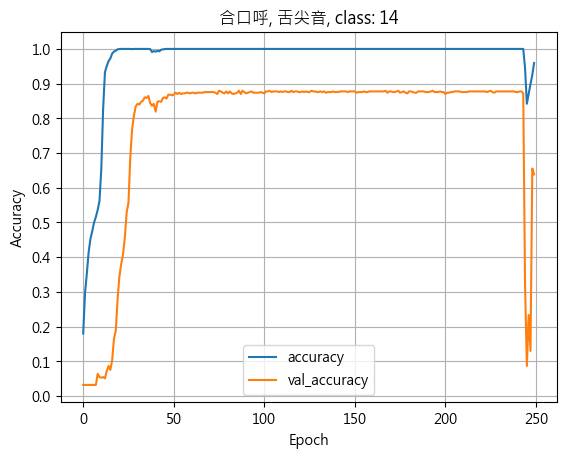

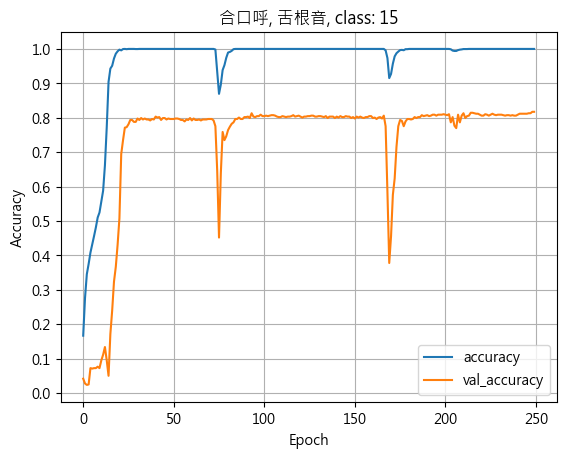

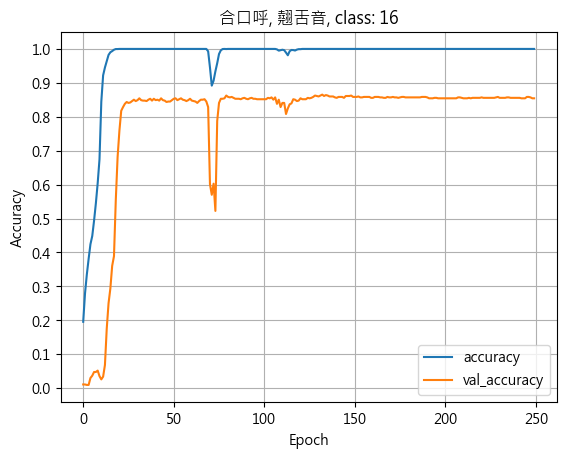

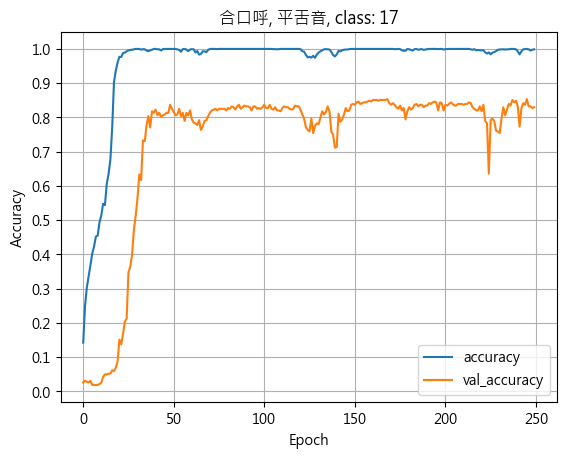

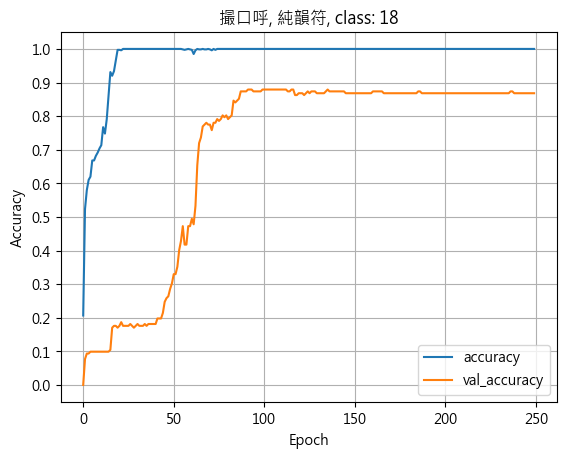

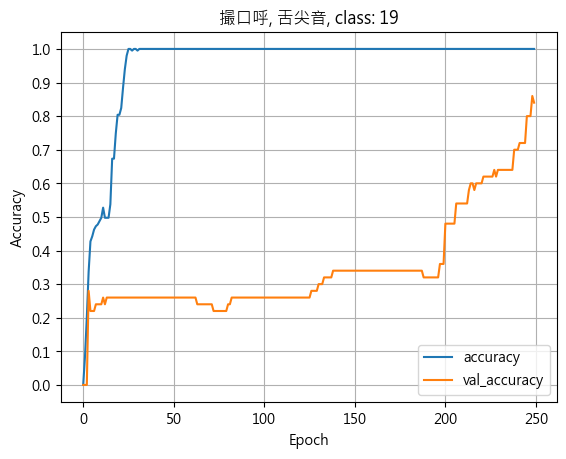

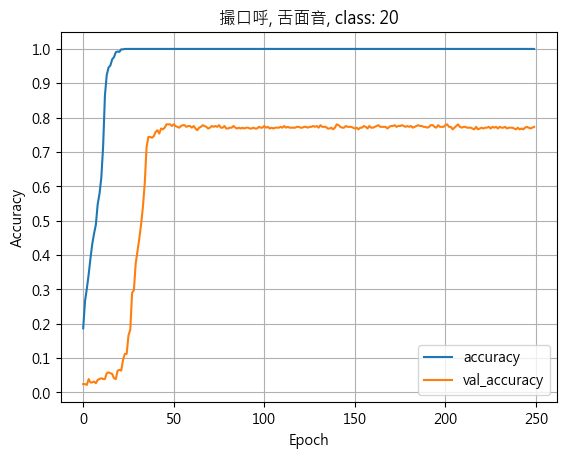

In [33]:
plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei"]
plt.rcParams["axes.unicode_minus"] = False

for class_label, model_train_info in enumerate(model_train_info_list):
    accuracies = model_train_info.history['accuracy']
    val_accuracies = model_train_info.history['val_accuracy']
    
    hu_yin = class_df.loc[class_df["class_label"] == class_label, "hu_yin"].values[0]
    she2_yin = class_df.loc[class_df["class_label"] == class_label, "she2_yin"].values[0]
    plt.title(f"{hu_yin}, {she2_yin}, class: {class_label}")
    
    plt.plot(list(range(epochs)), accuracies, label = "accuracy")
    plt.plot(list(range(epochs)), val_accuracies, label = "val_accuracy")
    plt.legend()
    plt.grid()
    plt.xticks(ticks = list(range(1, epochs + 1))) 
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.xticks(ticks=list(range(0, epochs + 1, 50)))
    plt.yticks(ticks=list(np.arange(0, 1 + 0.1, 0.1)))
    plt.show()

In [37]:
best_accuracy_list = list()

for class_label, model_train_info in enumerate(model_train_info_list):
    val_accuracies = model_train_info.history['val_accuracy']
    best_accuracy = max(val_accuracies)
    hu_yin = class_df.loc[class_df["class_label"] == class_label, "hu_yin"].values[0]
    she2_yin = class_df.loc[class_df["class_label"] == class_label, "she2_yin"].values[0]
    print(f"class: {class_label}, {hu_yin}, {she2_yin}, 最高準確率: {best_accuracy}")
    best_accuracy_list.append(best_accuracy)

class: 0, 純聲符, 翹舌音, 最高準確率: 0.8883572816848755
class: 1, 純聲符, 平舌音, 最高準確率: 0.7988165616989136
class: 2, 開口呼, 純韻符, 最高準確率: 0.9396226406097412
class: 3, 開口呼, 口唇音, 最高準確率: 0.8828490972518921
class: 4, 開口呼, 舌尖音, 最高準確率: 0.8552722334861755
class: 5, 開口呼, 舌根音, 最高準確率: 0.8677777647972107
class: 6, 開口呼, 翹舌音, 最高準確率: 0.8613861203193665
class: 7, 開口呼, 平舌音, 最高準確率: 0.88852459192276
class: 8, 齊齒呼, 純韻符, 最高準確率: 0.9037854671478271
class: 9, 齊齒呼, 口唇音, 最高準確率: 0.8145833611488342
class: 10, 齊齒呼, 舌尖音, 最高準確率: 0.8757467269897461
class: 11, 齊齒呼, 舌面音, 最高準確率: 0.8126220107078552
class: 12, 合口呼, 純韻符, 最高準確率: 0.8760107755661011
class: 13, 合口呼, 口唇音, 最高準確率: 0.9473684430122375
class: 14, 合口呼, 舌尖音, 最高準確率: 0.8794726729393005
class: 15, 合口呼, 舌根音, 最高準確率: 0.8172942996025085
class: 16, 合口呼, 翹舌音, 最高準確率: 0.8653061389923096
class: 17, 合口呼, 平舌音, 最高準確率: 0.8534278869628906
class: 18, 撮口呼, 純韻符, 最高準確率: 0.8791208863258362
class: 19, 撮口呼, 舌尖音, 最高準確率: 0.8600000143051147
class: 20, 撮口呼, 舌面音, 最高準確率: 0.7804877758026123


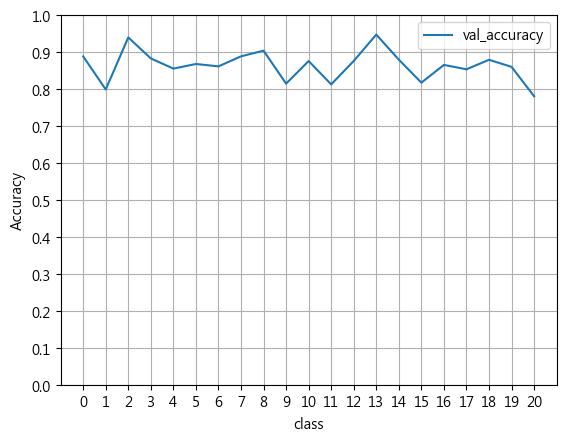

In [42]:
plt.plot(range(len(best_accuracy_list)), best_accuracy_list, label = "val_accuracy")
plt.legend()
plt.grid()
plt.xticks(ticks=list(range(1, len(best_accuracy_list) + 1))) 
plt.xlabel("class")
plt.ylabel("Accuracy")
plt.xticks(ticks=range(len(best_accuracy_list)))
plt.yticks(ticks=list(np.arange(0, 1 + 0.1, 0.1)))
plt.show()